<a href="https://colab.research.google.com/github/FalakFatima11/Autobase1.0/blob/main/Multi_drone_battery_constraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Algorithm: Multi-Drone Delivery Scheduling (Battery-Constrained)

#### Inputs:
- Closed-loop carrier path: series of waypoints
- Customer locations
- Drone and carrier speeds (`v_drone`, `v_carrier`)
- Drone battery capacity (maximum flight distance per charge)
- Number of drones
- Parameter `p` (drone departure condition)

#### Step 1: Initialization
- **ComputeCumulativeDistances(path)**:
  - Calculate distances between waypoints and accumulate distances along the path.

#### Step 2: Helper Functions
- **PointAtArcLength(s, cumulative_distances, path)**:
  - Compute exact point on carrier's path at arc length `s`.

- **CarrierPosition(t, v_carrier)**:
  - Find carrier's position at time `t` based on speed.

- **FindMeetingPoint(s_departure, customer, p)**:
  - Use bisection method to find suitable meeting point for drone and carrier after delivery.

#### Step 3: Drone Battery Management
- **Drone Class**:
  - Initialize drones with battery capacity.
  - **CanFly(distance)**: Check if drone can fly the given distance.
  - **ConsumeBattery(distance)**: Update drone battery after flight.
  - **Recharge()**: Reset drone battery to full.

#### Step 4: Partial Chain Delivery Scheduling
- **ScheduleDeliveries(s_candidate_first, customers)**:
  - For each customer sequentially:
    1. Identify drone pickup point (current carrier position).
    2. Compute distances:
       - Pickup to customer (`dxp`)
       - Customer to carrier meeting (`dc`)
    3. Verify battery constraints:
       - Recharge or switch drone if insufficient battery.
       - Skip customer if infeasible.
    4. Record delivery details (drone ID, distances, battery, pickup/meeting points).

#### Step 5: Search Optimal Initial Pickup (`s_candidate_first`)
- **FindOptimalPickupPoint(path, customers, num_candidates)**:
  - Test various initial pickup points:
    1. Maximize customers served.
    2. Minimize total drone flight distance.
  - Select optimal initial pickup based on above criteria.

#### Step 6: Detailed Assignment Reporting
- Using optimal initial pickup point:
  - Confirm drone assignments.
  - Report:
    - Total drone flight distance
    - Number of customers served/skipped
    - Drone battery statuses after each assignment

#### Step 7: Calculate Delivery Times
- **CalculateTotalTime(assignments)**:
  - For each drone assignment:
    - Calculate flight durations (pickup-customer, customer-meeting)
    - Accumulate total elapsed operational time.

#### Outputs:
- Optimal initial pickup point (`s_candidate_first`)
- Detailed delivery assignments (customer, drone, distances, battery usage, locations)
- Summary metrics (total distance, customers served/skipped, operational time)



In [1]:
# Cell 1: Parameters, Initial Setup, and Helper Functions

import numpy as np
import matplotlib.pyplot as plt

# Animation sampling time (s)
dt_anim = 0.1

# Carrier's closed-loop path (meters)
points = np.array([
    [0, 0],
    [1000, 0],
    [2000, 0],
    [2000, 2000],
    [1000, 2000],
    [1000, 4000],
    [0, 4000],
    [0, 0]
], dtype=float)

# Customer locations (global coordinates)
customers = [
    np.array([-5000, 3000]),
    np.array([-4500, 2500]),
    np.array([-4000, 2000]),
    np.array([-3500, 1500]),
    np.array([-1000, 1000]),
    np.array([2000, 1500]),
    np.array([10500, 3000]),
    np.array([5000, 2500])
]

# Speeds: Drone 8 m/s, Carrier 4 m/s
v_drone = 8.0
v_carrier = 4.0

# Battery parameters
drone_range_max = 10000.0
battery_capacity = drone_range_max * 2

# Number of drones available
num_drones = 3

# Parameter p: carrier travels (direct drone distance)/p before departure; here p = 2
p = 2

# Precompute cumulative arc-length along the carrier's path
cum_dist = np.zeros(len(points))
for i in range(1, len(points)):
    cum_dist[i] = cum_dist[i-1] + np.linalg.norm(points[i] - points[i-1])
L_total = cum_dist[-1]

# Helper function: Given a distance s along the path, return the (x, y) position.
def point_at_arc_length(s):
    s_mod = s % L_total
    i = np.searchsorted(cum_dist, s_mod) - 1
    i = max(0, min(i, len(points)-2))
    t = (s_mod - cum_dist[i]) / (cum_dist[i+1] - cum_dist[i])
    return points[i] + t * (points[i+1] - points[i])

# Wrap around function
def point_at_arc_length_loop(s):
    return point_at_arc_length(s % L_total)

# Function to compute the carrier position if it moved at constant speed v_carrier
def carrier_position(t):
    return point_at_arc_length(v_carrier * t)

# Function to solve for s_meet using bisection so that:
# distance( point_at_arc_length_loop(s_departure + s_meet), customer ) = p * s_meet
def find_s_meet(s_departure, customer, p):
    s_max = 2 * L_total
    def f(s_meet):
        pt = point_at_arc_length_loop(s_departure + s_meet)
        return np.linalg.norm(pt - customer) - p * s_meet
    if f(0) * f(s_max) > 0:
        return None
    tol = 1e-6
    s_low, s_high = 0.0, s_max
    for _ in range(100):
        s_mid = 0.5 * (s_low + s_high)
        if abs(f(s_mid)) < tol:
            return s_mid
        if f(s_low) * f(s_mid) <= 0:
            s_high = s_mid
        else:
            s_low = s_mid
    return 0.5 * (s_low + s_high)


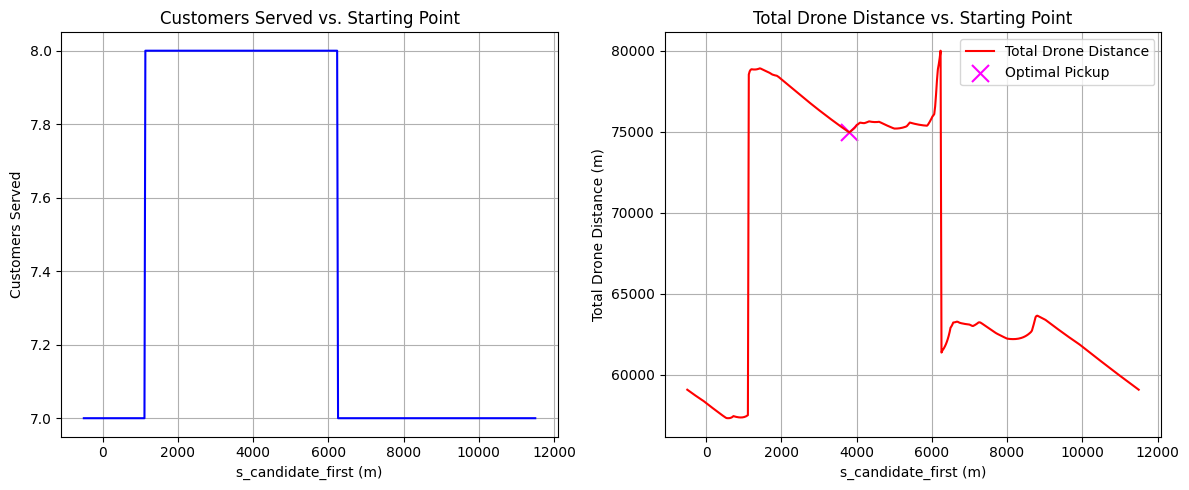

Optimal s_candidate_first (battery-constrained):
  s = 3804.6 m
  Total drone distance = 74955.1 m
  Customers served = 8 out of 8
  No customers were skipped.


In [2]:
# Cell 2: Drone Class, Delivery Chain Simulation, and Optimal Candidate Search

# Define the Drone class.
class Drone:
    def __init__(self, id, capacity=battery_capacity):
        self.id = id
        self.battery = capacity
    def can_fly(self, distance):
        return self.battery >= distance
    def consume(self, distance):
        self.battery -= distance
    def recharge(self, capacity=battery_capacity):
        self.battery = capacity

# Function to simulate a chain of deliveries from a candidate starting position.
# It returns total distance flown, assignment details, the drones, and any skipped customers.
def chain_deliveries_multi_partial(s_candidate_first, customers, capacity=battery_capacity, num_drones=num_drones):
    drones = [Drone(i+1, capacity) for i in range(num_drones)]
    current_drone_idx = 0
    s_candidate = s_candidate_first
    total_distance = 0.0
    assignments = []
    skipped_customers = []

    for cust_idx, customer in enumerate(customers, start=1):
        pickup = point_at_arc_length_loop(s_candidate)
        dxp = np.linalg.norm(customer - pickup)
        Dxp_cr = dxp / p
        s_departure = s_candidate + Dxp_cr
        s_meet = find_s_meet(s_departure, customer, p)
        if s_meet is None:
            skipped_customers.append({'customer_idx': cust_idx, 'reason': 'No valid meeting point'})
            continue
        meeting = point_at_arc_length_loop(s_departure + s_meet)
        dc = np.linalg.norm(meeting - customer)
        flight_dist = dxp + dc

        drone = drones[current_drone_idx]
        if not drone.can_fly(flight_dist):
            drone.recharge(capacity)
            current_drone_idx = (current_drone_idx + 1) % num_drones
            drone = drones[current_drone_idx]
        if not drone.can_fly(flight_dist):
            skipped_customers.append({'customer_idx': cust_idx, 'reason': 'Battery limit exceeded'})
            continue

        drone.consume(flight_dist)
        total_distance += flight_dist
        assignments.append({
            'customer_idx': cust_idx,
            'drone_id': drone.id,
            'pickup_pt': pickup,
            'meeting_pt': meeting,
            'flight_distance': flight_dist,
            'remaining_battery': drone.battery,
            'dxp': dxp,
            's_departure': s_candidate + dxp / p,
            's_meet': s_meet
        })
        s_candidate = s_departure + s_meet

    return total_distance, assignments, drones, skipped_customers

# SEARCH: Loop over candidate starting values.
num_candidates = 500
s_candidates = np.linspace(-500, L_total - 500, num_candidates)

results = []
for s in s_candidates:
    tot_dist, assigns, _, skipped = chain_deliveries_multi_partial(s, customers)
    served = len(assigns) if tot_dist is not None else 0
    results.append({
        's': s,
        'total_distance': tot_dist if tot_dist is not None else np.inf,
        'served': served,
        'skipped': skipped
    })

# Select the candidate with maximum customers served and minimal total distance.
max_served = max(r['served'] for r in results)
candidates_max = [r for r in results if r['served'] == max_served]
optimal_candidate = min(candidates_max, key=lambda r: r['total_distance'])

# Plot the results.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(s_candidates, [r['served'] for r in results], 'b-')
plt.xlabel("s_candidate_first (m)")
plt.ylabel("Customers Served")
plt.title("Customers Served vs. Starting Point")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(s_candidates, [r['total_distance'] for r in results], 'r-', label='Total Drone Distance')
plt.scatter(optimal_candidate['s'], optimal_candidate['total_distance'], color='magenta', marker='x', s=150, label='Optimal Pickup')
plt.xlabel("s_candidate_first (m)")
plt.ylabel("Total Drone Distance (m)")
plt.title("Total Drone Distance vs. Starting Point")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Optimal s_candidate_first (battery-constrained):")
print(f"  s = {optimal_candidate['s']:.1f} m")
print(f"  Total drone distance = {optimal_candidate['total_distance']:.1f} m")
print(f"  Customers served = {optimal_candidate['served']} out of {len(customers)}")
if optimal_candidate['skipped']:
    print("  Skipped customers:")
    for s_res in optimal_candidate['skipped']:
        print(f"    Customer {s_res['customer_idx']}: {s_res['reason']}")
else:
    print("  No customers were skipped.")


In [3]:
# Cell 3: Re-run Simulation with Optimal Candidate and Compute Cumulative Time

# Use the optimal candidate from Cell 2.
s_candidate_first_opt = optimal_candidate['s']
total_dist_opt, assignments_opt, drones_used_opt, skipped_opt = chain_deliveries_multi_partial(s_candidate_first_opt, customers)
print(f"\nUsing optimal s_candidate_first = {s_candidate_first_opt:.1f} m:")
print(f"  Total delivered distance: {total_dist_opt:.1f} m")
print(f"  Customers served: {len(assignments_opt)} out of {len(customers)}")

# Print detailed assignment information.
print("\nAssignment Details:")
for a in assignments_opt:
    print(f"Customer {a['customer_idx']} served by Drone {a['drone_id']}:")
    print(f"  Pickup point: {a['pickup_pt']}")
    print(f"  Meeting point: {a['meeting_pt']}")
    print(f"  Flight distance: {a['flight_distance']:.1f} m, Remaining battery: {a['remaining_battery']:.1f}")

# Add cumulative time to each assignment.
assignments_opt_with_time = []
t_cumulative = 0.0
for a in assignments_opt:
    T1 = a['dxp'] / v_drone  # Time for outbound flight (pickup -> customer)
    dc = np.linalg.norm(a['meeting_pt'] - customers[a['customer_idx'] - 1])
    T2 = dc / v_drone        # Time for return flight (customer -> meeting)
    a['total_time'] = t_cumulative + T1 + T2
    t_cumulative += (T1 + T2)
    assignments_opt_with_time.append(a)
assignments_opt = assignments_opt_with_time



Using optimal s_candidate_first = 3804.6 m:
  Total delivered distance: 74955.1 m
  Customers served: 8 out of 8

Assignment Details:
Customer 1 served by Drone 1:
  Pickup point: [2000.         1804.60921844]
  Meeting point: [   0.         2104.98662272]
  Flight distance: 12180.8 m, Remaining battery: 7819.2
Customer 2 served by Drone 2:
  Pickup point: [   0.         2104.98662272]
  Meeting point: [2000.         1446.10711587]
  Flight distance: 11102.2 m, Remaining battery: 8897.8
Customer 3 served by Drone 3:
  Pickup point: [2000.         1446.10711587]
  Meeting point: [   0.         3419.01499283]
  Flight distance: 10269.8 m, Remaining battery: 9730.2
Customer 4 served by Drone 3:
  Pickup point: [   0.         3419.01499283]
  Meeting point: [902.08280496   0.        ]
  Flight distance: 8642.2 m, Remaining battery: 1088.0
Customer 5 served by Drone 1:
  Pickup point: [902.08280496   0.        ]
  Meeting point: [2000.        1496.9942856]
  Flight distance: 5189.8 m, Rema

In [ ]:
# Cell 4: Build Animation Segments, Precompute Positions, and Run Animation

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Build animation segments for the drone.
# Each assignment produces two segments: Outbound (pickup -> customer) and Return (customer -> meeting).
segments = []  # Each segment is a dict with: t0, duration, start, end, drone_id
t0 = 0.0
for a in assignments_opt:
    T1 = a['dxp'] / v_drone  # Outbound time (pickup -> customer)
    segments.append({
        't0': t0,
        'duration': T1,
        'start': a['pickup_pt'],
        'end': customers[a['customer_idx'] - 1],
        'drone_id': a['drone_id']
    })
    t0 += T1
    dc = np.linalg.norm(a['meeting_pt'] - customers[a['customer_idx'] - 1])
    T2 = dc / v_drone        # Return time (customer -> meeting)
    segments.append({
        't0': t0,
        'duration': T2,
        'start': customers[a['customer_idx'] - 1],
        'end': a['meeting_pt'],
        'drone_id': a['drone_id']
    })
    t0 += T2
T_total = t0

# Compute final arc-length for the carrier.
# Here we use the last assignment's (s_departure + s_meet) as the final arc-length.
if assignments_opt:
    s_final = assignments_opt[-1]['s_departure'] + assignments_opt[-1]['s_meet']
else:
    s_final = s_candidate_first_opt
T_total_carrier = (s_final - s_candidate_first_opt) / v_carrier

# Define a constant-speed carrier position function.
def get_carrier_position_const(t):
    # Carrier moves at constant 4 m/s starting from s_candidate_first_opt.
    return point_at_arc_length_loop(s_candidate_first_opt + v_carrier * t)

# Functions to get positions for animation.
def get_segment_pos(seg, t):
    if t < seg['t0']:
        return seg['start']
    elif t > seg['t0'] + seg['duration']:
        return seg['end']
    frac = (t - seg['t0']) / seg['duration']
    return seg['start'] + frac * (seg['end'] - seg['start'])

def get_drone_position(t):
    # Return the position and drone_id for time t by finding the appropriate segment.
    for seg in segments:
        if seg['t0'] <= t < seg['t0'] + seg['duration']:
            return get_segment_pos(seg, t), seg['drone_id']
    return segments[-1]['end'], segments[-1]['drone_id']

# Precompute positions for animation.
# Total animation time is the maximum of the drone's simulation time and the carrier's constant-speed time.
T_anim = max(T_total, T_total_carrier)
time_vec = np.arange(0, T_anim + dt_anim/2, dt_anim)
drone_positions = np.zeros((len(time_vec), 2))
carrier_positions_anim = np.zeros((len(time_vec), 2))
drone_ids = np.zeros(len(time_vec), dtype=int)
for i, t in enumerate(time_vec):
    pos, d_id = get_drone_position(t)
    drone_positions[i] = pos
    drone_ids[i] = d_id
    carrier_positions_anim[i] = get_carrier_position_const(t)

# Subsample time vector for a slower animation.
frame_step = 10  # Adjust as needed
time_vec_sub = time_vec[::frame_step]
drone_positions_sub = drone_positions[::frame_step]
carrier_positions_sub = carrier_positions_anim[::frame_step]
drone_ids_sub = drone_ids[::frame_step]

# Map drone ids to colors.
drone_colors = {1: 'blue', 2: 'green', 3: 'orange'}

# Set up the animation figure.
fig_anim, ax_anim = plt.subplots(figsize=(10,6))
ax_anim.plot(points[:,0], points[:,1], '-o', color='gray', label='Carrier Path')
# Plot customers with markers.
for i, cust in enumerate(customers, start=1):
    if i in [a['customer_idx'] for a in assignments_opt]:
        marker, color = '*', 'green'
    elif any(s['customer_idx'] == i for s in skipped_opt):
        marker, color = 'x', 'red'
    else:
        marker, color = 'o', 'black'
    ax_anim.scatter(cust[0], cust[1], c=color, marker=marker, s=100)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 1 (blue)', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 2 (green)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 3 (orange)', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Carrier', markerfacecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='*', color='w', label='Served Customer', markerfacecolor='green', markersize=12),
    plt.Line2D([0], [0], marker='x', color='w', label='Skipped Customer', markerfacecolor='red', markersize=12)
]
ax_anim.legend(handles=legend_elements, loc='upper right')
ax_anim.set_xlabel("X (m)")
ax_anim.set_ylabel("Y (m)")
ax_anim.set_title("Multi-Drone Delivery Animation (Constant Speeds)")
ax_anim.grid(True)

carrier_marker, = ax_anim.plot([], [], 'ks', ms=10, label='Carrier')
drone_marker, = ax_anim.plot([], [], 'o', ms=12, label='Active Drone')
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=12)

# Animation update function.
def update(frame):
    t = time_vec_sub[frame]
    cpos = carrier_positions_sub[frame]
    carrier_marker.set_data([cpos[0]], [cpos[1]])
    dpos = drone_positions_sub[frame]
    d_id = drone_ids_sub[frame]
    drone_marker.set_color(drone_colors.get(d_id, 'black'))
    drone_marker.set_data([dpos[0]], [dpos[1]])
    served_so_far = sum(1 for a in assignments_opt if a['total_time'] <= t)
    time_text.set_text(f"Time = {t:.1f} s\nActive Drone: {d_id}\nCustomers served: {served_so_far}/{len(customers)}")
    return carrier_marker, drone_marker, time_text

ani = FuncAnimation(fig_anim, update, frames=len(time_vec_sub),
                    interval=(dt_anim*1000)/12, blit=True)

# For Colab, display the animation as an HTML5 video.
from IPython.display import HTML, display
html_video = ani.to_html5_video()
display(HTML(html_video))

print(f"Total flight time (finite battery, multi-drone): {T_anim:.1f} s")


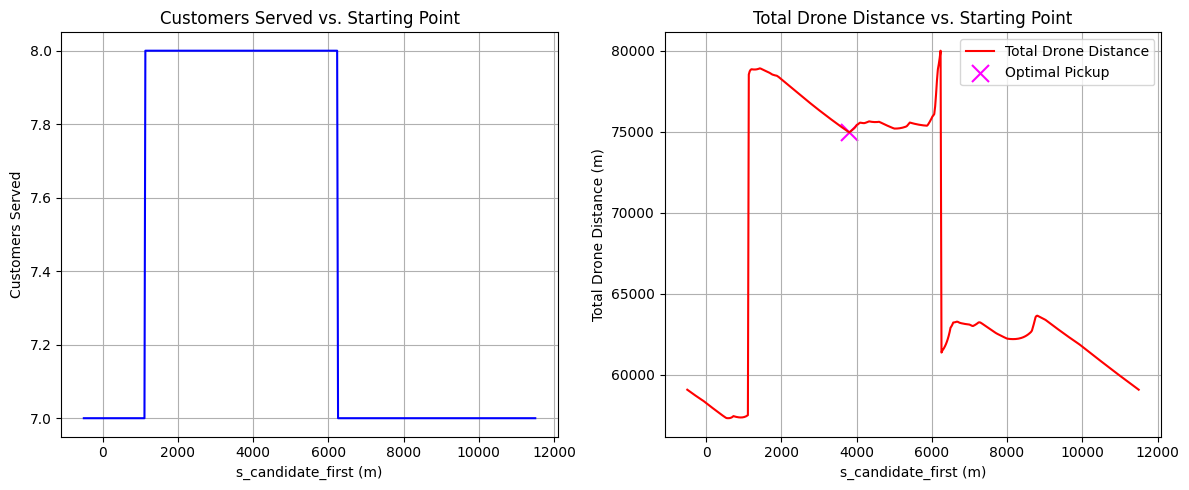

Optimal s_candidate_first (battery-constrained):
  s = 3804.6 m
  Total drone distance = 74955.1 m
  Customers served = 8 out of 8
  No customers were skipped.

Using optimal s_candidate_first = 3804.6 m:
  Total delivered distance: 74955.1 m
  Customers served: 8 out of 8

Assignment Details:
Customer 1 served by Drone 1:
  Pickup point: [2000.         1804.60921844]
  Meeting point: [   0.         2104.98662272]
  Flight distance: 12180.8 m, Remaining battery: 7819.2
Customer 2 served by Drone 2:
  Pickup point: [   0.         2104.98662272]
  Meeting point: [2000.         1446.10711587]
  Flight distance: 11102.2 m, Remaining battery: 8897.8
Customer 3 served by Drone 3:
  Pickup point: [2000.         1446.10711587]
  Meeting point: [   0.         3419.01499283]
  Flight distance: 10269.8 m, Remaining battery: 9730.2
Customer 4 served by Drone 3:
  Pickup point: [   0.         3419.01499283]
  Meeting point: [902.08280496   0.        ]
  Flight distance: 8642.2 m, Remaining battery:

Total flight time (finite battery, multi-drone): 9369.4 s


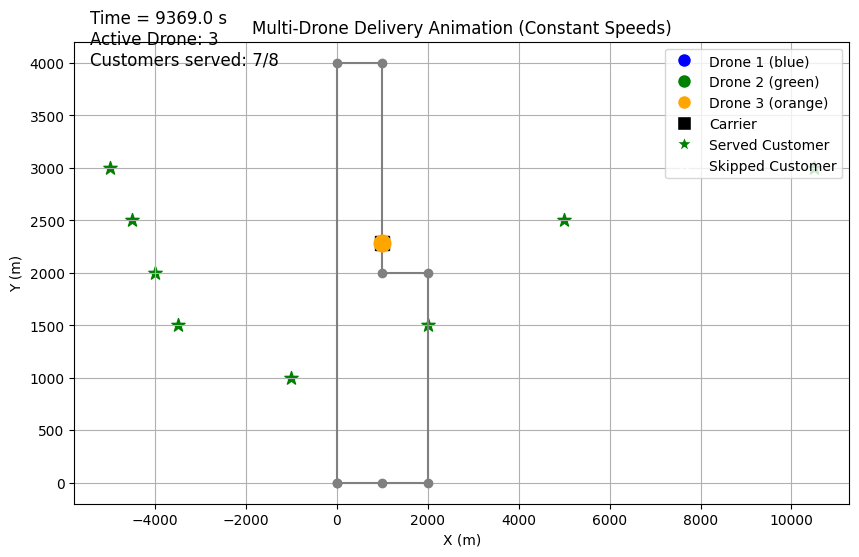

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# -------------------------------
# 1) PARAMETERS & INITIAL SETUP
# -------------------------------
dt_anim = 0.1  # Animation sampling time (s)

# Carrier's closed-loop path (meters)
points = np.array([
    [0, 0],
    [1000, 0],
    [2000, 0],
    [2000, 2000],
    [1000, 2000],
    [1000, 4000],
    [0, 4000],
    [0, 0]
], dtype=float)

# Customer locations (global coordinates)
customers = [
    np.array([-5000, 3000]),
    np.array([-4500, 2500]),
    np.array([-4000, 2000]),
    np.array([-3500, 1500]),
    np.array([-1000, 1000]),
    np.array([2000, 1500]),
    np.array([10500, 3000]),
    np.array([5000, 2500])
]

v_drone = 8.0    # Drone speed in m/s
v_carrier = 4.0  # Carrier speed in m/s

# Battery parameters: maximum one-way range and round-trip capacity (m)
drone_range_max = 10000.0
battery_capacity = drone_range_max * 2

# Number of drones available
num_drones = 3

# Parameter: Carrier travels a distance equal to (direct drone distance)/p before drone departs.
p = 2  # (typically, p = v_drone/v_carrier)

# ---------------------------------------------------
# Precompute cumulative arc-length along the carrier's path
# ---------------------------------------------------
cum_dist = np.zeros(len(points))
for i in range(1, len(points)):
    cum_dist[i] = cum_dist[i-1] + np.linalg.norm(points[i] - points[i-1])
L_total = cum_dist[-1]

# ---------------------------------------------------
# Helper Functions
# ---------------------------------------------------
def point_at_arc_length(s):
    s_mod = s % L_total
    i = np.searchsorted(cum_dist, s_mod) - 1
    i = max(0, min(i, len(points)-2))
    t = (s_mod - cum_dist[i]) / (cum_dist[i+1] - cum_dist[i])
    return points[i] + t * (points[i+1] - points[i])

def point_at_arc_length_loop(s):
    return point_at_arc_length(s % L_total)

def carrier_position(t):
    # Carrier moves at constant speed v_carrier
    return point_at_arc_length(v_carrier * t)

def find_s_meet(s_departure, customer, p):
    s_max = 2 * L_total
    def f(s_meet):
        pt = point_at_arc_length_loop(s_departure + s_meet)
        return np.linalg.norm(pt - customer) - p * s_meet
    if f(0) * f(s_max) > 0:
        return None
    tol = 1e-6
    s_low, s_high = 0.0, s_max
    for _ in range(100):
        s_mid = 0.5 * (s_low + s_high)
        if abs(f(s_mid)) < tol:
            return s_mid
        if f(s_low) * f(s_mid) <= 0:
            s_high = s_mid
        else:
            s_low = s_mid
    return 0.5 * (s_low + s_high)

# ---------------------------------------------------
# Drone class for battery tracking
# ---------------------------------------------------
class Drone:
    def __init__(self, id, capacity=battery_capacity):
        self.id = id
        self.battery = capacity
    def can_fly(self, distance):
        return self.battery >= distance
    def consume(self, distance):
        self.battery -= distance
    def recharge(self, capacity=battery_capacity):
        self.battery = capacity

# ---------------------------------------------------
# Partial-chain delivery (battery-constrained)
# If a delivery is infeasible, skip that customer.
# ---------------------------------------------------
def chain_deliveries_multi_partial(s_candidate_first, customers, capacity=battery_capacity, num_drones=num_drones):
    drones = [Drone(i+1, capacity) for i in range(num_drones)]
    current_drone_idx = 0
    s_candidate = s_candidate_first
    total_distance = 0.0
    assignments = []
    skipped_customers = []

    for cust_idx, customer in enumerate(customers, start=1):
        pickup = point_at_arc_length_loop(s_candidate)
        dxp = np.linalg.norm(customer - pickup)
        Dxp_cr = dxp / p
        s_departure = s_candidate + Dxp_cr
        s_meet = find_s_meet(s_departure, customer, p)
        if s_meet is None:
            skipped_customers.append({'customer_idx': cust_idx, 'reason': 'No valid meeting point'})
            continue
        meeting = point_at_arc_length_loop(s_departure + s_meet)
        dc = np.linalg.norm(meeting - customer)
        flight_dist = dxp + dc

        drone = drones[current_drone_idx]
        if not drone.can_fly(flight_dist):
            drone.recharge(capacity)
            current_drone_idx = (current_drone_idx + 1) % num_drones
            drone = drones[current_drone_idx]
        if not drone.can_fly(flight_dist):
            skipped_customers.append({'customer_idx': cust_idx, 'reason': 'Battery limit exceeded'})
            continue

        drone.consume(flight_dist)
        total_distance += flight_dist
        assignments.append({
            'customer_idx': cust_idx,
            'drone_id': drone.id,
            'pickup_pt': pickup,
            'meeting_pt': meeting,
            'flight_distance': flight_dist,
            'remaining_battery': drone.battery,
            'dxp': dxp,
            's_departure': s_candidate + dxp / p,
            's_meet': s_meet
        })
        s_candidate = s_departure + s_meet

    return total_distance, assignments, drones, skipped_customers

# ====================================================
# SEARCH OVER s_candidate_first (Battery-Constrained)
# ====================================================
num_candidates = 500
s_candidates = np.linspace(-500, L_total - 500, num_candidates)

results = []
for s in s_candidates:
    tot_dist, assigns, _, skipped = chain_deliveries_multi_partial(s, customers)
    served = len(assigns) if tot_dist is not None else 0
    results.append({
        's': s,
        'total_distance': tot_dist if tot_dist is not None else np.inf,
        'served': served,
        'skipped': skipped
    })

max_served = max(r['served'] for r in results)
candidates_max = [r for r in results if r['served'] == max_served]
optimal_candidate = min(candidates_max, key=lambda r: r['total_distance'])

# Plot the search results and highlight the optimal pickup point.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(s_candidates, [r['served'] for r in results], 'b-')
plt.xlabel("s_candidate_first (m)")
plt.ylabel("Customers Served")
plt.title("Customers Served vs. Starting Point")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(s_candidates, [r['total_distance'] for r in results], 'r-', label='Total Drone Distance')
plt.scatter(optimal_candidate['s'], optimal_candidate['total_distance'], color='magenta', marker='x', s=150, label='Optimal Pickup')
plt.xlabel("s_candidate_first (m)")
plt.ylabel("Total Drone Distance (m)")
plt.title("Total Drone Distance vs. Starting Point")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Optimal s_candidate_first (battery-constrained):")
print(f"  s = {optimal_candidate['s']:.1f} m")
print(f"  Total drone distance = {optimal_candidate['total_distance']:.1f} m")
print(f"  Customers served = {optimal_candidate['served']} out of {len(customers)}")
if optimal_candidate['skipped']:
    print("  Skipped customers:")
    for s_res in optimal_candidate['skipped']:
        print(f"    Customer {s_res['customer_idx']}: {s_res['reason']}")
else:
    print("  No customers were skipped.")

# ====================================================
# Re-run the partial-chain delivery using the optimal candidate.
# ====================================================
s_candidate_first_opt = optimal_candidate['s']
total_dist_opt, assignments_opt, drones_used_opt, skipped_opt = chain_deliveries_multi_partial(s_candidate_first_opt, customers)
print(f"\nUsing optimal s_candidate_first = {s_candidate_first_opt:.1f} m:")
print(f"  Total delivered distance: {total_dist_opt:.1f} m")
print(f"  Customers served: {len(assignments_opt)} out of {len(customers)}")

# Print detailed assignment information.
print("\nAssignment Details:")
for a in assignments_opt:
    print(f"Customer {a['customer_idx']} served by Drone {a['drone_id']}:")
    print(f"  Pickup point: {a['pickup_pt']}")
    print(f"  Meeting point: {a['meeting_pt']}")
    print(f"  Flight distance: {a['flight_distance']:.1f} m, Remaining battery: {a['remaining_battery']:.1f}")

# ---------------------------------------------------
# Add cumulative time to each assignment.
# ---------------------------------------------------
assignments_opt_with_time = []
t_cumulative = 0.0
for a in assignments_opt:
    T1 = a['dxp'] / v_drone
    dc = np.linalg.norm(a['meeting_pt'] - customers[a['customer_idx'] - 1])
    T2 = dc / v_drone
    a['total_time'] = t_cumulative + T1 + T2
    t_cumulative += (T1 + T2)
    assignments_opt_with_time.append(a)
assignments_opt = assignments_opt_with_time

# ====================================================
# Build animation segments from assignments.
# Each assignment gives two segments: Outbound (pickup -> customer) and Return (customer -> meeting).
# The drone moves at constant speed v_drone.
# ====================================================
segments = []  # Each segment: dict with t0, duration, start, end, drone_id
t0 = 0.0
for a in assignments_opt:
    T1 = a['dxp'] / v_drone  # constant-speed flight time for outbound leg
    segments.append({
        't0': t0,
        'duration': T1,
        'start': a['pickup_pt'],
        'end': customers[a['customer_idx'] - 1],
        'drone_id': a['drone_id']
    })
    t0 += T1
    dc = np.linalg.norm(a['meeting_pt'] - customers[a['customer_idx'] - 1])
    T2 = dc / v_drone      # constant-speed flight time for return leg
    segments.append({
        't0': t0,
        'duration': T2,
        'start': customers[a['customer_idx'] - 1],
        'end': a['meeting_pt'],
        'drone_id': a['drone_id']
    })
    t0 += T2
T_total = t0

# Build carrier segments.
# The carrier moves at constant speed v_carrier.
carrier_segments = []
t0_carrier = 0.0
s_current = s_candidate_first_opt
for a in assignments_opt:
    # During the drone's outbound leg, carrier covers a distance equal to (dxp)/p.
    T1_carrier = (a['dxp'] / p) / v_carrier
    carrier_segments.append({
        't0': t0_carrier,
        'duration': T1_carrier,
        's0': s_current
    })
    t0_carrier += T1_carrier
    # During the return leg, carrier moves a distance equal to s_meet.
    T2_carrier = a['s_meet'] / v_carrier
    carrier_segments.append({
        't0': t0_carrier,
        'duration': T2_carrier,
        's0': s_current + a['dxp'] / p
    })
    t0_carrier += T2_carrier
    s_current = a['s_departure'] + a['s_meet']

# ====================================================
# Functions to get positions at any time t for animation.
# ====================================================
def get_segment_pos(seg, t):
    if t < seg['t0']:
        return seg['start']
    elif t > seg['t0'] + seg['duration']:
        return seg['end']
    frac = (t - seg['t0']) / seg['duration']
    return seg['start'] + frac * (seg['end'] - seg['start'])

def get_drone_position(t):
    # Find the current drone segment and interpolate.
    for seg in segments:
        if seg['t0'] <= t < seg['t0'] + seg['duration']:
            return get_segment_pos(seg, t), seg['drone_id']
    return segments[-1]['end'], segments[-1]['drone_id']

def get_carrier_position(t):
    for seg in carrier_segments:
        if seg['t0'] <= t < seg['t0'] + seg['duration']:
            s = seg['s0'] + v_carrier * (t - seg['t0'])
            return point_at_arc_length_loop(s)
    last = carrier_segments[-1]
    s_final = last['s0'] + v_carrier * last['duration']
    return point_at_arc_length_loop(s_final)

# ====================================================
# Precompute positions for animation.
# ====================================================
time_vec = np.arange(0, T_total + dt_anim/2, dt_anim)
drone_positions = np.zeros((len(time_vec), 2))
carrier_positions_anim = np.zeros((len(time_vec), 2))
drone_ids = np.zeros(len(time_vec), dtype=int)
for i, t in enumerate(time_vec):
    pos, d_id = get_drone_position(t)
    drone_positions[i] = pos
    drone_ids[i] = d_id
    carrier_positions_anim[i] = get_carrier_position(t)

# Subsample time vector for slower animation.
frame_step = 10  # Adjust as needed
time_vec_sub = time_vec[::frame_step]
drone_positions_sub = drone_positions[::frame_step]
carrier_positions_sub = carrier_positions_anim[::frame_step]
drone_ids_sub = drone_ids[::frame_step]

# Map drone id to color (1: blue, 2: green, 3: orange)
drone_colors = {1: 'blue', 2: 'green', 3: 'orange'}

# ====================================================
# Set up the animation figure.
# ====================================================
fig_anim, ax_anim = plt.subplots(figsize=(10,6))
ax_anim.plot(points[:,0], points[:,1], '-o', color='gray', label='Carrier Path')
# Plot customers with markers indicating served or skipped.
for i, cust in enumerate(customers, start=1):
    if i in [a['customer_idx'] for a in assignments_opt]:
        marker, color = '*', 'green'
    elif any(s['customer_idx'] == i for s in skipped_opt):
        marker, color = 'x', 'red'
    else:
        marker, color = 'o', 'black'
    ax_anim.scatter(cust[0], cust[1], c=color, marker=marker, s=100)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 1 (blue)', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 2 (green)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Drone 3 (orange)', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Carrier', markerfacecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='*', color='w', label='Served Customer', markerfacecolor='green', markersize=12),
    plt.Line2D([0], [0], marker='x', color='w', label='Skipped Customer', markerfacecolor='red', markersize=12)
]
ax_anim.legend(handles=legend_elements, loc='upper right')
ax_anim.set_xlabel("X (m)")
ax_anim.set_ylabel("Y (m)")
ax_anim.set_title("Multi-Drone Delivery Animation (Constant Speeds)")
ax_anim.grid(True)

carrier_marker, = ax_anim.plot([], [], 'ks', ms=10, label='Carrier')
drone_marker, = ax_anim.plot([], [], 'o', ms=12, label='Active Drone')
time_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, fontsize=12)

# ====================================================
# Animation update function.
# ====================================================
def update(frame):
    t = time_vec_sub[frame]
    cpos = carrier_positions_sub[frame]
    carrier_marker.set_data([cpos[0]], [cpos[1]])
    dpos = drone_positions_sub[frame]
    d_id = drone_ids_sub[frame]
    drone_marker.set_color(drone_colors.get(d_id, 'black'))
    drone_marker.set_data([dpos[0]], [dpos[1]])
    served_so_far = sum(1 for a in assignments_opt if a['total_time'] <= t)
    time_text.set_text(f"Time = {t:.1f} s\nActive Drone: {d_id}\nCustomers served: {served_so_far}/{len(customers)}")
    return carrier_marker, drone_marker, time_text

ani = FuncAnimation(fig_anim, update, frames=len(time_vec_sub),
                    interval=(dt_anim*1000)/30, blit=True)

# For Colab, display the animation as an HTML5 video.
html_video = ani.to_html5_video()
display(HTML(html_video))

print(f"Total flight time (finite battery, multi-drone): {T_total:.1f} s")
